# Style transfer

In [1]:
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
torch.backends.cudnn.benchmark = True

## Data

In [4]:
PATH = Path('data/imagenet/')

In [5]:
 TRN_PATH = PATH/'train'

In [6]:
img_filename = TRN_PATH/'n01558993'/'n01558993_9684.JPEG'

In [19]:
img = open_image(img_filename)

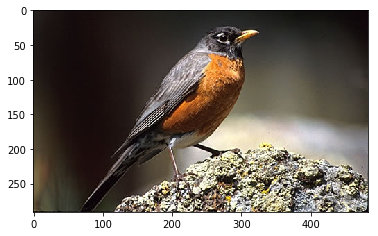

In [20]:
plt.imshow(img)

In [11]:
model = vgg16(pre=True).cuda().eval()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/fabiograetz/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [05:49<00:00, 1582954.99it/s]


In [12]:
set_trainable(model, False)

In [15]:
sz = 228

In [16]:
train_tfms, val_tfms = tfms_from_model(vgg16, sz)

In [21]:
transformed_img = val_tfms(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


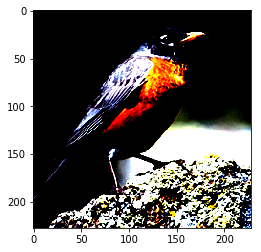

In [23]:
plt.imshow(transformed_img.transpose(1,2,0))

In [24]:
transformed_img.shape

(3, 228, 228)

## Create a random image

In [38]:
start_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)

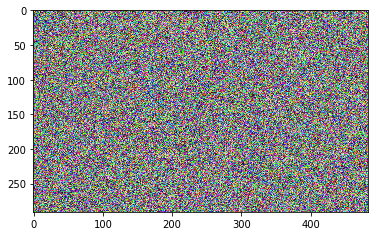

In [39]:
plt.imshow(start_img)

Hint: training starts much better if the picture is blurred/more even looking

In [40]:
start_img = scipy.ndimage.filters.median_filter(start_img, [8, 8, 1])

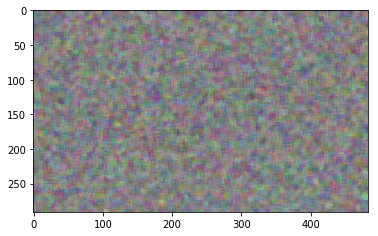

In [41]:
plt.imshow(start_img)

**We convert this starting image to a variable that *requires gradients*!**

In [42]:
start_img = val_tfms(start_img)/2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


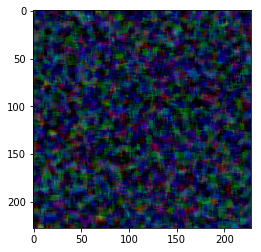

In [43]:
plt.imshow(start_img.transpose(1,2,0))

In [44]:
start_img_var = V(start_img[None], requires_grad=True)

In [45]:
start_img_var.shape

torch.Size([1, 3, 228, 228])

**Content loss: returns a lower number if the picture looks more like the bird. We use a 'perceptual loss' which means that instead of comparing the pixel values of the generated image to the bird image (which would give an exact copy of the bird), we calculate the loss from specific (arbitrarily chosen) activations in a later layer of a neural network. If two pictures cause 'similar activations' they should look similar while not being the same.**

**Let's grab an activation from a later layer:**

In [51]:
model = nn.Sequential(*list(model.children())[:37])

**Let's calculate the target activations of our bird image. Gradients not required!**

In [54]:
targ_act = model(V(transformed_img[None], requires_grad=False))  # slicing with None creates a unit axis <=> bs=1

In [55]:
targ_act.shape

torch.Size([1, 512, 14, 14])

**Loss function:**

### Style loss: returns a lower number if the picture is closer to Van Gogh's style